# Astro Lab Book 2025

In [3]:
import astropy
import astroquery
import ccdproc
from astropy.nddata import CCDData
from astropy.time.time_helper.function_helpers import linspace
from ccdproc import ccd_process
import numpy as np
from pathlib import Path
import ccdproc as ccdp
from astropy import units as u
import matplotlib.pyplot as plt
import photutils.background as bg
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from photutils.utils import calc_total_error
from photutils.segmentation import SourceCatalog
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.background import MedianBackground
import os
import glob
import astroalign
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astroquery.simbad import Simbad
from astropy.table import Table, hstack, join
from astropy.io import ascii
from astropy.stats import sigma_clip
import astroalign as aa
from astropy.cosmology import FlatLambdaCDM

### Combined Bias

In [2]:
raw_data = Path('data/V1/bias')

calibrated_biases = glob.glob(str(raw_data / '*.fit*'))

combined_bias = ccdp.combine(calibrated_biases,
                             method='average',
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_bias.meta['combined'] = True
combined_bias.write(raw_data / 'combined_bias.fit', overwrite=True)

INFO: splitting each image into 11 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


### Dark Frame Cleaning

In [22]:
path_dark_raw = 'data/V1/darks'
combined_bias = astropy.nddata.CCDData.read('data/V1/bias/combined_bias.fit', unit='adu')

for file_path in glob.glob(os.path.join(path_dark_raw,'*.fits')):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    file_name = os.path.basename(file_path)
    ccd.write('data/V1/darks/bias_subtracted_' + file_name, overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[[ 955.   954.6  950.8 ...  976.8  987.4 1004.2]
 [ 951.8  953.6  951.6 ...  979.4  992.8  997.4]
 [ 952.8  953.6  957.6 ...  983.4  981.2  989. ]
 ...
 [ 964.   958.   958.8 ...  988.2 1003.2 1018.6]
 [ 959.8  957.8  963.4 ...  997.8 1001.6 1018.6]
 [ 967.6  957.6  960.8 ...  987.8 1002.6 1013.6]] adu


In [13]:
path_subtracted_dark_data = Path('data/V1/darks')

dark_file_paths = glob.glob(str(path_subtracted_dark_data / 'bias_subtracted_*.dark.*.fits'))

combined_darks = ccdp.combine(dark_file_paths,
                             method='median',
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_darks.meta['combined'] = True
combined_darks.write('data/V1/darks/combined_darks.fit', overwrite=True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 23 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the uni

### Cleaning B-Filter Flats

In [150]:
def normalise(arr, mean):
    arr.data[:] = arr.data / mean
    return arr

In [25]:
combined_bias = ccdp.CCDData.read('data/V1/bias/combined_bias.fit', unit='adu')
combined_darks = ccdp.CCDData.read('data/V1/darks/combined_darks.fit', unit='adu')

seconds_unit = u.s

for file_path in glob.glob(os.path.join('data/V1/flat_B/*.fits')):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_darks, exposure_time='EXPTIME', exposure_unit = seconds_unit)
    ccd_mean =  np.mean(ccd)
    ccd = normalise(ccd, ccd_mean)
    file_name = os.path.basename(file_path)
    ccd.write('data/V1/flat_B/cleaned_' + file_name, overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
4.261372911930075 adu


In [32]:
calibrated_flats = glob.glob('data/V1/flat_B/*.fit')

combined_flats = ccdp.combine(calibrated_flats,
                             method='median',
                             mem_limit=350e6,
                             unit = 'adu'
                            )

combined_flats.meta['combined'] = True
combined_flats.write('data/V1/flat_B/combined_flats_B.fits', overwrite = True)

['data/flat_B\\combined_flats_B.fit']
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000203564953D0>>
Traceback (most recent call last):
  File "C:\Users\alpha\PycharmProjects\JupyterProject\.venv1\Lib\site-packages\ipykernel\ipkernel.py", line 812, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alpha\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1535, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


KeyboardInterrupt: 

### Cleaning the R Flats

In [4]:
def normalise(arr, mean):
    arr.data[:] = arr.data / mean
    return arr

combined_bias = ccdp.CCDData.read('data/V1/bias/combined_bias.fit', unit='adu')
combined_darks = ccdp.CCDData.read('data/V1/darks/combined_darks.fit', unit='adu')

seconds_unit = u.s

for file_path in glob.glob(os.path.join('data/V1/flat_R/*.fits')):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_darks, exposure_time='EXPTIME', exposure_unit = seconds_unit)
    ccd_mean =  np.mean(ccd)
    ccd = normalise(ccd, ccd_mean)
    file_name = os.path.basename(file_path)
    ccd.write('data/V1/flat_R/cleaned_' + file_name, overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [7]:
calibrated_flats = glob.glob('data/V1/flat_R/*.fits')

combined_flats = ccdp.combine(calibrated_flats,
                             method='median',
                             mem_limit=350e6,
                             unit = 'adu'
                            )

combined_flats.meta['combined'] = True
combined_flats.write('data/V1/flat_R/combined_flats_R.fits', overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 16 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the uni

### Cleaning the R band Science Images

In [33]:
combined_dark = ccdp.CCDData.read('data/V1/darks/combined_darks.fit', unit='adu')
combined_bias = ccdp.CCDData.read('data/V1/bias/combined_bias.fit', unit='adu')
combined_flat = ccdp.CCDData.read('data/V1/flat_R/combined_flats_R.fits', unit='adu')
print(combined_flat)
cleaned_science_path = Path('data/V1/science_R')

i = 36
for file_path in cleaned_science_path.glob('*.fits'):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_dark, exposure_time='EXPTIME', exposure_unit = seconds_unit, scale = True)
    ccd = ccdp.ccd_process(ccd, master_flat = combined_flat, exposure_key='EXPTIME', exposure_unit = seconds_unit)
    ccd.write(cleaned_science_path / f'{i}.fits', overwrite = True)
    i += 1

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


[[0.93776151 0.92525077 0.92578427 ... 0.91589084 0.89803776 0.05013559]
 [0.94007327 0.93862275 0.93671111 ... 0.9140623  0.9074273  0.05586547]
 [0.93321216 0.94519542 0.94365425 ... 0.91514226 0.9044326  0.05638898]
 ...
 [0.95690537 0.95300715 0.95094661 ... 0.93945292 0.91475504 0.05529003]
 [0.95613864 0.9524027  0.9488018  ... 0.93998262 0.92795337 0.0548105 ]
 [0.95065897 0.94152379 0.94814179 ... 0.93407178 0.92419765 0.05256037]] adu


### Cleaning the B band Science Images

In [13]:
combined_dark = ccdp.CCDData.read('data/V1/darks/combined_darks.fit', unit='adu')
combined_bias = ccdp.CCDData.read('data/V1/bias/combined_bias.fit', unit='adu')
combined_flat = ccdp.CCDData.read('data/V1/flat_B/combined_flats_B.fit', unit='adu')
cleaned_science_path = Path('data/V1/science_B')

i = 31
for file_path in cleaned_science_path.glob('*.fits'):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_dark, exposure_time='EXPTIME', exposure_unit = seconds_unit, scale = True)
    ccd = ccdp.ccd_process(ccd, master_flat = combined_flat, exposure_key='EXPTIME', exposure_unit = seconds_unit)
    ccd.write(cleaned_science_path / f'{i}.fits', overwrite = True)
    i += 1

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


### Identifying sources

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


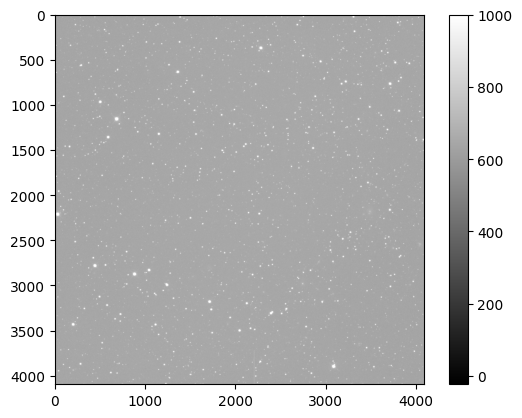

In [10]:
img = ccdp.CCDData.read('data/science_R/36.fits', unit='adu')
plt.imshow(img, vmin = -23, vmax = 1000,cmap='gray')
plt.colorbar()

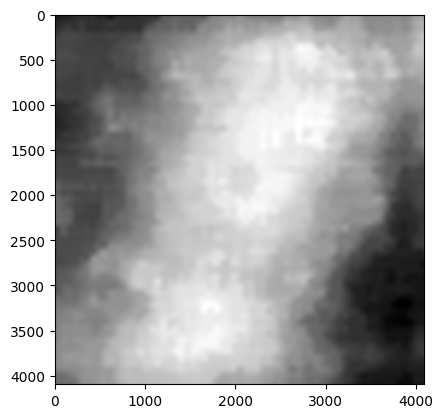

In [11]:
background = bg.Background2D(img, box_size= 65, filter_size = 5, bkg_estimator=MedianBackground())
mean = background.background_median
rms = background.background_rms_median

plt.imshow(np.asarray(background.background), cmap='gray')
plt.show()

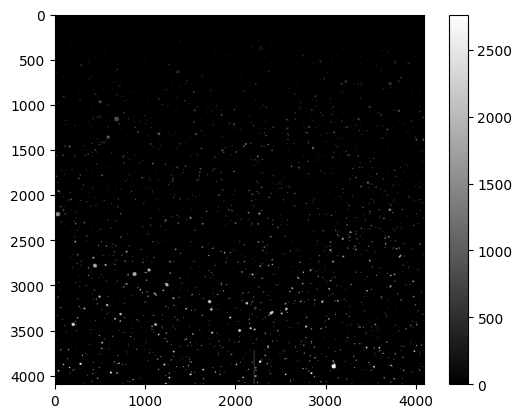

In [12]:
threshold = background.background + rms * 2

kernel = make_2dgaussian_kernel(3,3)
convolved_data = convolve(img, kernel)

segment_map = detect_sources(convolved_data * u.adu, threshold, npixels=5)
plt.imshow(segment_map, cmap='gray')
plt.colorbar()
plt.show()


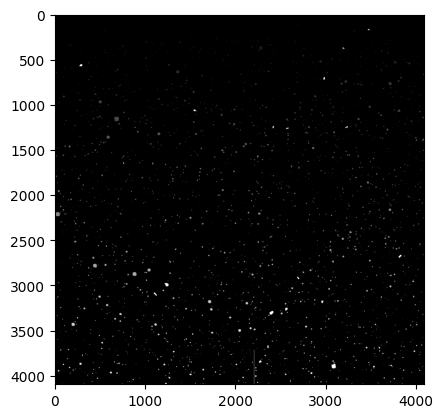

In [13]:
segm_deblend = deblend_sources(convolved_data, segment_map,
                               npixels = 25, nlevels = 32, contrast = 0.001,
                               progress_bar = True)

plt.imshow(segm_deblend, cmap='gray')

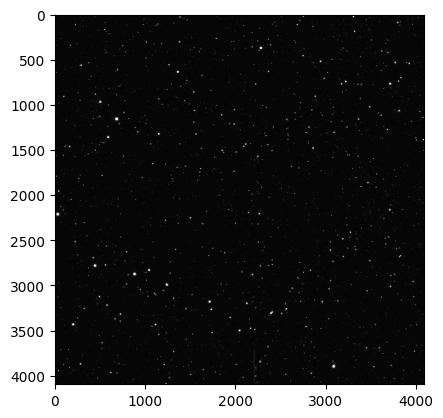

In [15]:
subtracted_background = img - background.background
plt.imshow(subtracted_background.data, cmap = 'gray', vmin = -23, vmax = 1000)

### Pixel values to RA and Dec

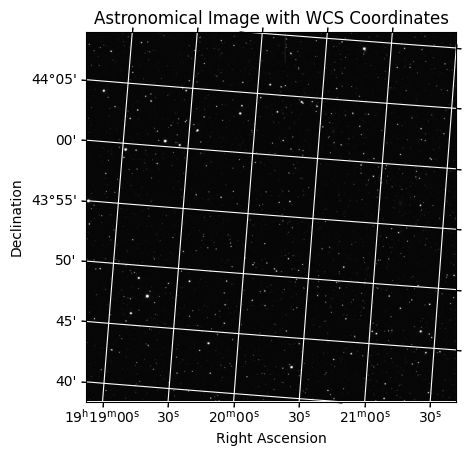

In [8]:
wcs_file = 'data/V1/wcs.fits'

wcs_header = fits.getheader(wcs_file, ext=0)
wcs = WCS(wcs_header)

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection=wcs)

ax.imshow(subtracted_background.data, origin='lower', cmap='gray', vmin = -23, vmax = 1000)

ax.coords.grid(True, color='white', ls='solid')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

plt.title('Astronomical Image with WCS Coordinates')
plt.show()

In [17]:
rms_array = background.background_rms
error = calc_total_error(np.array(subtracted_background), np.asarray(rms_array), 2.2)

source_catalog = SourceCatalog(data = np.asarray(subtracted_background), segment_img= segm_deblend, convolved_data = np.array(convolved_data), error = np.asarray(error), wcs= wcs)

image_table = source_catalog.to_table()

### Parse SIMBAD CDS for specific glaxies with known recessional velocity

In [11]:
filename = 'data/simbad.txt'
galaxy_table = ascii.read(filename, format='csv')

print(f"Table length {len(galaxy_table)}.")
print("Column names:", galaxy_table.colnames)

Table length 317.
Column names: ['#', 'obj_tags', 'obj_count', 'raw_id', 'identifier', 'typ', 'RA', 'Dec', 'Mag_U', 'Mag_B', 'Mag_V', 'Mag_R', 'Mag_I', 'spec_type', 'bib', 'not']


In [51]:
galaxy_coords = SkyCoord(ra=galaxy_table['RA'], dec=galaxy_table['Dec'], unit=(u.hourangle, u.deg))
#print(galaxy_coords)

source_coords = image_table['sky_centroid']
#print(source_coords)

idx, separation_2d, _ = galaxy_coords.match_to_catalog_sky(source_coords)
#print(separation_2d)

max_separation = 1.5 * u.arcsec
is_match = separation_2d < max_separation
num_matches = np.sum(is_match)
print(f"{num_matches} matches within a {max_separation} radius")


matched_galaxies = galaxy_table[is_match]
matched_sources = image_table[idx[is_match]]
matched_galaxies['separation_arcsec'] = separation_2d[is_match].to(u.arcsec)

final_table = hstack([matched_galaxies, matched_sources], join_type='exact', table_names=['simbad', 'image'])


useful_cols = ['identifier', 'typ', 'separation_arcsec', 'kron_flux', 'segment_flux', 'RA', 'Dec']
final_cols = [c for c in useful_cols if c in final_table.colnames]
final_table[final_cols].pprint_all()


18 matches within a 1.5 arcsec radius
       identifier       typ separation_arcsec       kron_flux          segment_flux             RA                 Dec        
                                  arcsec                                                                                      
----------------------- --- ------------------ ------------------- ------------------- ------------------- -------------------
2MASX J19192555+4405063 GiC 1.4230415704971517  27724.628213690994   1520.085599588394 19 19 25.5938951712 +44 05 06.239269140
2MASX J19192570+4342463 GiC 0.4893986735587412  278.03752336141883   308.4101326511693        19 19 25.708        +43 42 46.34
2MASX J19194300+4405083 GiC 1.4734344771778907 -1501.2737547510014  -1156.779420770631 19 19 43.0141404888 +44 05 07.962425592
2MASX J19200066+4405095 GiC 0.6937016374867457   27683.61956822782  1968.5507568777189 19 20 00.6877052016 +44 05 09.992713380
2MASX J19201015+4344496 GiC 1.4033752927807022   59880.67861963324   428.

<SkyCoord (ICRS): (ra, dec) in deg
    [(289.85664123, 44.08506646), (289.85711667, 43.71287222),
     (289.92922559, 44.08554512), (289.94309699, 44.01643332),
     (290.00286544, 44.08610909), (290.04145075, 43.85607878),
     (290.04150612, 43.79214981), (290.04237376, 43.74707574),
     (290.0791403 , 43.81055892), (290.08000526, 44.14244077),
     (290.08321026, 43.97639078), (290.09866787, 43.84515554),
     (290.13374975, 44.01327461), (290.13577536, 44.01845184),
     (290.13966499, 44.1212949 ), (290.16021832, 44.12137076),
     (290.17085524, 44.14593561), (290.17196612, 43.95469996),
     (290.17598559, 43.94369105), (290.17741385, 43.8810901 ),
     (290.18079747, 44.0472278 ), (290.20562464, 44.05628522),
     (290.20935158, 44.05514489), (290.23220964, 44.08400123),
     (290.24658485, 43.8899321 ), (290.25214965, 44.12668606),
     (290.26323001, 43.89461834), (290.26537673, 43.9524071 ),
     (290.26650258, 43.98809085), (290.27684424, 43.7964212 ),
     (290.2796625 , 

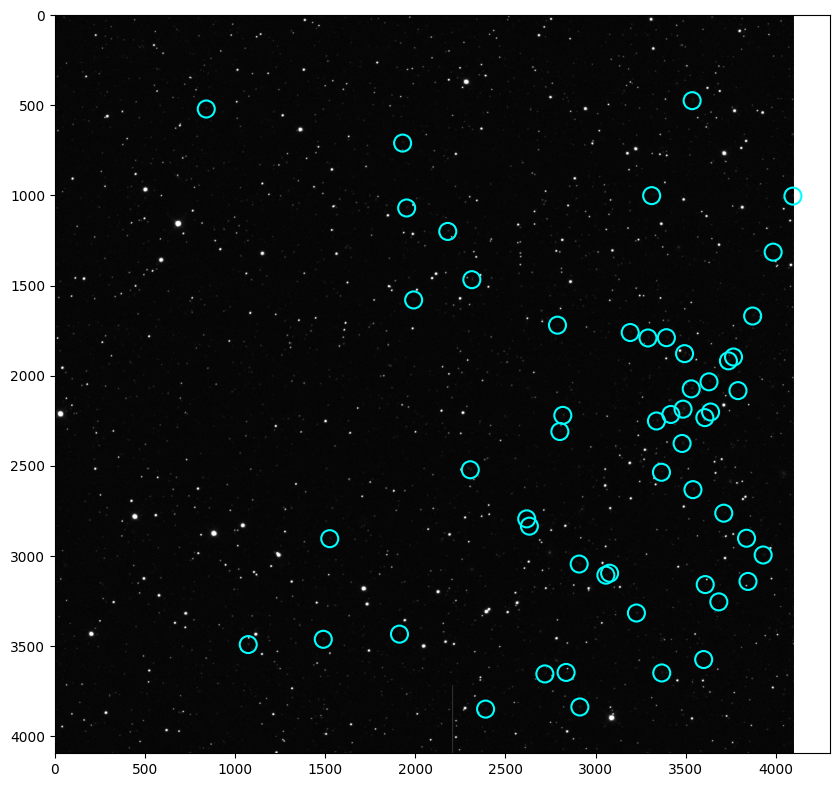

In [22]:
matched_coords = SkyCoord(ra=final_table['RA'],
                          dec=final_table['Dec'],
                          unit=(u.hourangle, u.deg))
print(matched_coords)
ra = matched_coords.ra.deg
dec = matched_coords.dec.deg

pixel_coords = wcs.world_to_pixel_values(ra,dec)
pixel_x = pixel_coords[0]
pixel_y = pixel_coords[1]
#pixel_x = final_table['xcentroid']
#pixel_y = final_table['ycentroid']

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(subtracted_background.data, cmap='gray', vmin = -23, vmax = 1000)
ax.scatter(pixel_x, pixel_y, marker='o', s=150, facecolors='none', edgecolors='cyan', lw=1.5, label='Matched SIMBAD Galaxies')
plt.show()

In [92]:
identifiers = final_table['identifier']
custom_simbad = Simbad()
custom_simbad.add_votable_fields('main_id')
custom_simbad.add_votable_fields('velocity')
redshift_results = custom_simbad.query_objects(identifiers)




In [140]:
files = sorted(glob.glob('data/V1/science_R/*.fits'))
output_stack = 'stacked_deep.fits'

ref_fn = files[0]
with fits.open(ref_fn) as hdul:
    ref_hdr = hdul[0].header.copy()
    ref_shape = hdul[0].data.shape

frames = []

for i, fn in enumerate(files):
    print(f"{i+1}/{len(files)} {fn}")

    with fits.open(fn) as hdul:
        hdr = hdul[0].header
        img = hdul[0].data.astype(float)

    bzero = hdr.get('BZERO', 0.0)
    bscale = hdr.get('BSCALE', 1.0)
    pedestal = hdr.get('PEDESTAL', 0.0)
    img = (img * bscale + bzero) - pedestal

    background = bg.Background2D(img, box_size= 65, filter_size = 5, bkg_estimator=MedianBackground())
    subtracted_background = img - background.background

    frames.append(subtracted_background)

cube = np.stack(frames, axis=0)

clipped = sigma_clip(cube, sigma=3.0, axis=0,
                        maxiters=4, masked=False)
combined = np.nanmean(clipped, axis=0)
combined = combined * len(frames)


#fits.writeto(output_stack, combined.astype(np.float32), out_hdr, overwrite=True)

1/5 data/V1/science_R\36.fits
2/5 data/V1/science_R\37.fits
3/5 data/V1/science_R\38.fits
4/5 data/V1/science_R\39.fits
5/5 data/V1/science_R\40.fits


### Combining Science Frames

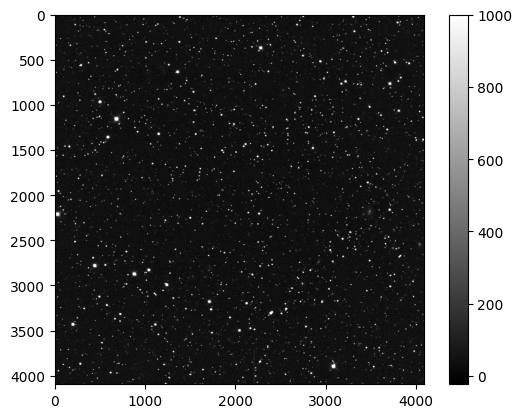

In [141]:
plt.imshow(combined, cmap ='gray', vmin = -23, vmax = 1000)
plt.colorbar()

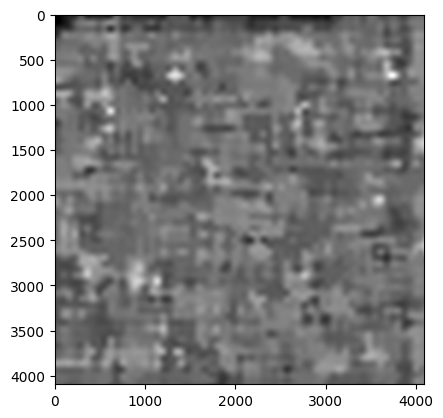

In [142]:
background = bg.Background2D(combined, box_size= 65, filter_size = 5, bkg_estimator=MedianBackground())
mean = background.background_median
rms = background.background_rms_median

plt.imshow(np.asarray(background.background), cmap='gray')

In [143]:
threshold = background.background + rms * 2

kernel = make_2dgaussian_kernel(3,3)
convolved_data = convolve(combined, kernel)

segment_map = detect_sources(convolved_data * u.adu, threshold * u.adu, npixels=5)

segm_deblend = deblend_sources(convolved_data, segment_map,
                               npixels = 25, nlevels = 32, contrast = 0.001,
                               progress_bar = True)

In [144]:
wcs_file = 'data/V1/wcs.fits'

wcs_header = fits.getheader(wcs_file, ext=0)
wcs = WCS(wcs_header)

In [145]:
rms_array = background.background_rms
error = calc_total_error(np.array(subtracted_background), np.asarray(rms_array), 2.2)

source_catalog = SourceCatalog(data = np.asarray(subtracted_background), segment_img= segm_deblend, convolved_data = np.array(convolved_data), error = np.asarray(error), wcs= wcs)

image_table = source_catalog.to_table()

In [146]:
galaxy_coords = SkyCoord(ra=galaxy_table['RA'], dec=galaxy_table['Dec'], unit=(u.hourangle, u.deg))

source_coords = image_table['sky_centroid']

idx, separation_2d, _ = galaxy_coords.match_to_catalog_sky(source_coords)

max_separation = 1.5 * u.arcsec
is_match = separation_2d < max_separation
num_matches = np.sum(is_match)
print(f"{num_matches} matches within a {max_separation} radius")


matched_galaxies = galaxy_table[is_match]
matched_sources = image_table[idx[is_match]]
matched_galaxies['separation_arcsec'] = separation_2d[is_match].to(u.arcsec)

final_table = hstack([matched_galaxies, matched_sources], join_type='exact', table_names=['simbad', 'image'])


useful_cols = ['identifier', 'typ', 'separation_arcsec', 'kron_flux', 'segment_flux', 'RA', 'Dec']
final_cols = [c for c in useful_cols if c in final_table.colnames]
final_table[final_cols].pprint_all()

48 matches within a 1.5 arcsec radius
       identifier       typ separation_arcsec      kron_flux         segment_flux             RA                 Dec        
                                  arcsec                                                                                    
----------------------- --- ------------------ ------------------ ------------------ ------------------- -------------------
2MASX J19192555+4405063 GiC 1.1637033759149713  26471.47132027588 12123.261907190432 19 19 25.5938951712 +44 05 06.239269140
2MASX J19194300+4405083 GiC  1.077439391801862 10523.853496766566  5147.872709525502 19 19 43.0141404888 +44 05 07.962425592
2MASX J19194633+4400593 GiC 0.9420876997477715  13968.91872937579 2946.8252499738783 19 19 46.3432786848 +44 00 59.159961396
2MASX J19200066+4405095 GiC 1.0698907756218599 15493.087118195263  4506.009833634024 19 20 00.6877052016 +44 05 09.992713380
2MASX J19200996+4351216 GiC 0.9634941789230654  8897.325453674304  2063.058544975338 19

<SkyCoord (ICRS): (ra, dec) in deg
    [(289.85664123, 44.08506646), (289.92922559, 44.08554512),
     (289.94309699, 44.01643332), (290.00286544, 44.08610909),
     (290.04145075, 43.85607878), (290.04150612, 43.79214981),
     (290.04237376, 43.74707574), (290.0791403 , 43.81055892),
     (290.08321026, 43.97639078), (290.09866787, 43.84515554),
     (290.13374975, 44.01327461), (290.13577536, 44.01845184),
     (290.16021832, 44.12137076), (290.17196612, 43.95469996),
     (290.17598559, 43.94369105), (290.17741385, 43.8810901 ),
     (290.18079747, 44.0472278 ), (290.20562464, 44.05628522),
     (290.20935158, 44.05514489), (290.23220964, 44.08400123),
     (290.24658485, 43.8899321 ), (290.26323001, 43.89461834),
     (290.26537673, 43.9524071 ), (290.26650258, 43.98809085),
     (290.27684424, 43.7964212 ), (290.2796625 , 43.94865   ),
     (290.28088562, 43.89536321), (290.28139117, 43.74314653),
     (290.2883625 , 43.96925   ), (290.29175103, 43.94559004),
     (290.29503656, 

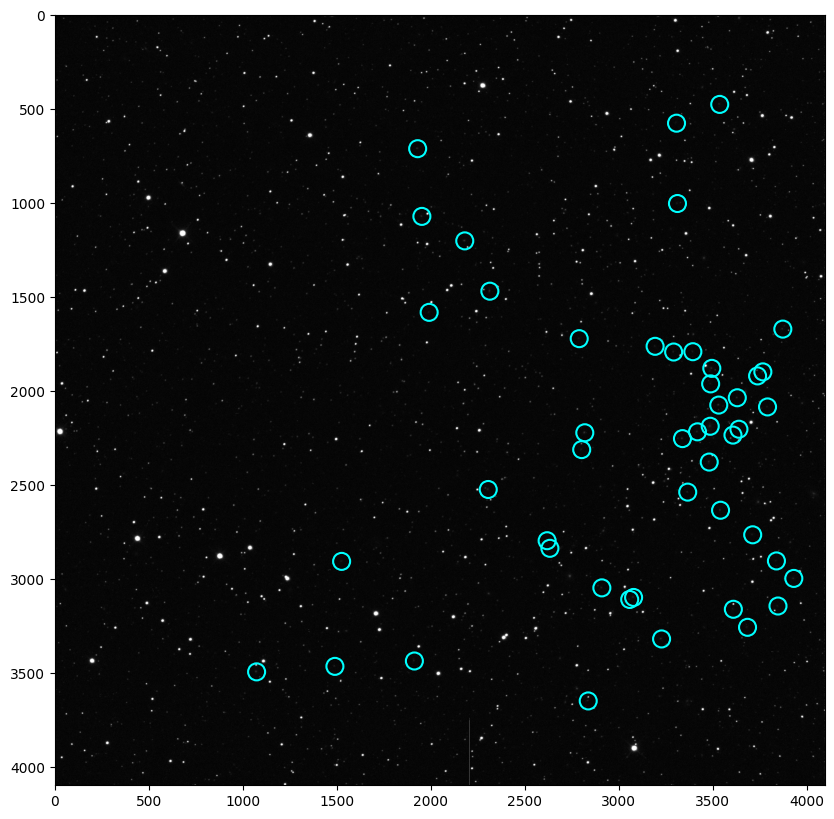

In [147]:
matched_coords = SkyCoord(ra=final_table['RA'],
                          dec=final_table['Dec'],
                          unit=(u.hourangle, u.deg))
print(matched_coords)
ra = matched_coords.ra.deg
dec = matched_coords.dec.deg

pixel_coords = wcs.world_to_pixel_values(ra,dec)
pixel_x = pixel_coords[0]
pixel_y = pixel_coords[1]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(subtracted_background.data, cmap='gray', vmin = -23, vmax = 1000)
ax.scatter(pixel_x, pixel_y, marker='o', s=150, facecolors='none', edgecolors='cyan', lw=1.5, label='Matched SIMBAD Galaxies')
plt.show()

### Finding Absolute Magnitude

In [148]:
identifiers = final_table['identifier']
custom_simbad = Simbad()
custom_simbad.add_votable_fields('main_id')
custom_simbad. add_votable_fields('velocity')
redshift_results = custom_simbad.query_objects(identifiers)

final_table['redshift'] = redshift_results['rvz_redshift']
final_table['radial_velocity'] = redshift_results['rvz_radvel']

final_table['identifier', 'redshift', 'radial_velocity', 'kron_flux']. pprint_all()

       identifier       redshift  radial_velocity       kron_flux     
                                       km / s                         
----------------------- -------- ------------------ ------------------
2MASX J19192555+4405063 0.051772 15119.593567830923  26471.47132027588
2MASX J19194300+4405083   0.0625 18152.570851376146 10523.853496766566
2MASX J19194633+4400593 0.051876 15149.160260435398  13968.91872937579
2MASX J19200066+4405095 0.058634 17063.531274748108 15493.087118195263
2MASX J19200996+4351216 0.054391  15863.18268356255  8897.325453674304
2MASX J19200996+4347316 0.057416 16719.505378819755  20724.25658346833
2MASX J19201015+4344496 0.052893  15438.11878770817 16592.104071584403
    NVSS J192017+434851 0.064635 18752.092813427986  26616.26203967811
2MASX J19201995+4358346 0.061005 17731.960253086163 15970.948731786197
2MASX J19202364+4350426 0.057523 16749.745343360646 24954.990816906004
2MASX J19203208+4400481 0.088658 25405.017408255993 13976.551217627995
2MASS 

In [149]:
zeropoint = 25.0

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
flux = final_table['kron_flux'].value

redshift = np.array(final_table['redshift']).astype(float)

app_mag = -2.5 * np.log10(flux) + zeropoint

dist_lum = cosmo.luminosity_distance(redshift).to(u.pc).value
dist_mod = 5 * np.log10(dist_lum / 10)
abs_mag = app_mag - dist_mod

final_table['app_mag_R'] = app_mag
final_table['abs_mag_R'] = abs_mag

final_table['identifier', 'redshift', 'app_mag_R', 'abs_mag_R'].pprint_all()


       identifier       redshift     app_mag_R           abs_mag_R     
----------------------- -------- ------------------ -------------------
2MASX J19192555+4405063 0.051772 13.943054798378785 -22.869928338458212
2MASX J19194300+4405083   0.0625 14.944563015963348 -22.293953404067828
2MASX J19194633+4400593 0.051876 14.637093023375868 -22.180410047621194
2MASX J19200066+4405095 0.058634 14.524655092655888 -22.569253521034316
2MASX J19200996+4351216 0.054391 15.126851307902772 -21.797370528270772
2MASX J19200996+4347316 0.057416 14.208802598565235 -22.837639933955955
2MASX J19201015+4344496 0.052893 14.450246342242172 -22.411000544908397
    NVSS J192017+434851 0.064635 13.937132341117355 -23.377597421831048
2MASX J19201995+4358346 0.061005  14.49167321110318 -22.691971254435867
2MASX J19202364+4350426 0.057523  14.00710646403059  -23.04354460491787
2MASX J19203208+4400481 0.088658  14.63649994914598 -23.400645149904385
2MASS J19203259+4401066 0.048077 15.654853408320346 -20.99156179

### Using V2 Data

In [9]:
raw_data = Path('data/V2/bias')

calibrated_biases = glob.glob(str(raw_data / '*.fit*'))

combined_bias = ccdp.combine(calibrated_biases,
                             method='average',
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_bias.meta['combined'] = True
combined_bias.write(raw_data / 'combined_bias.fit', overwrite=True)

['data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002126.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002127.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002128.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002129.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002130.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002131.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002132.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002133.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002134.fit', 'data\\V2\\bias\\Bias_Entered Coordinates_0.000secs_R_00002135.fit']


Set OBSGEO-Y to  -131185.767 from OBSGEO-[LBH].
Set OBSGEO-Z to  5055549.706 from OBSGEO-[LBH]'. [astropy.wcs.wcs]


INFO: splitting each image into 22 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


In [11]:
path_dark_raw = 'data/V2/darks'
combined_bias = astropy.nddata.CCDData.read('data/V2/bias/combined_bias.fit', unit='adu')

for file_path in glob.glob(os.path.join(path_dark_raw,'*.fit')):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    file_name = os.path.basename(file_path)
    ccd.write('data/V2/darks/bias_subtracted_' + file_name, overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [15]:
path_subtracted_dark_data = Path('data/V2/darks')

dark_file_paths = glob.glob(str(path_subtracted_dark_data / 'bias_subtracted_*.fit'))

combined_darks = ccdp.combine(dark_file_paths,
                             method='median',
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_darks.meta['combined'] = True
combined_darks.write('data/V2/darks/combined_darks.fit', overwrite=True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 32 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the uni

In [16]:
combined_bias = ccdp.CCDData.read('data/V2/bias/combined_bias.fit', unit='adu')
combined_darks = ccdp.CCDData.read('data/V2/darks/combined_darks.fit', unit='adu')

seconds_unit = u.s

for file_path in glob.glob(os.path.join('data/V2/flat_R/*.fit')):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_darks, exposure_time='EXPTIME', exposure_unit = seconds_unit)
    ccd_mean =  np.mean(ccd)
    ccd = normalise(ccd, ccd_mean)
    file_name = os.path.basename(file_path)
    ccd.write('data/V2/flat_R/cleaned_' + file_name, overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [18]:
calibrated_flats = glob.glob('data/V2/flat_R/*.fit')

combined_flats = ccdp.combine(calibrated_flats,
                             method='median',
                             mem_limit=350e6,
                             unit = 'adu'
                            )

combined_flats.meta['combined'] = True
combined_flats.write('data/V2/flat_R/combined_flats_R.fit', overwrite = True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 16 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the uni

In [21]:
combined_dark = ccdp.CCDData.read('data/V2/darks/combined_darks.fit', unit='adu')
combined_bias = ccdp.CCDData.read('data/V2/bias/combined_bias.fit', unit='adu')
combined_flat = ccdp.CCDData.read('data/V2/flat_R/combined_flats_R.fit', unit='adu')
cleaned_science_path = Path('data/V2/science_R')

i = 1
for file_path in cleaned_science_path.glob('*.fit'):
    ccd = ccdp.CCDData.read(file_path, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    ccd = ccdp.subtract_dark(ccd, combined_dark, exposure_time='EXPTIME', exposure_unit = seconds_unit, scale = True)
    ccd = ccdp.ccd_process(ccd, master_flat = combined_flat, exposure_key='EXPTIME', exposure_unit = seconds_unit)
    ccd.write(cleaned_science_path / f'{i}.fits', overwrite = True)
    i += 1

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [5]:
wcs_file = 'data/V2/wcs.fits'

wcs_header = fits.getheader(wcs_file, ext=0)
wcs = WCS(wcs_header)

In [6]:
files = sorted(glob.glob('data/V2/science_R/*.fits'))
output_stack = 'stacked_deep.fits'

ref_fn = files[0]
with fits.open(ref_fn) as hdul:
    ref_hdr = hdul[0].header.copy()
    ref_raw = hdul[0].data.astype(float)
    bzero = hdul[0].header.get('BZERO', 0.0)
    bscale = hdul[0].header.get('BSCALE', 1.0)
    pedestal = hdul[0].header.get('PEDESTAL', 0.0)
    ref_img = (ref_raw * bscale + bzero) - pedestal

ref_background = bg.Background2D(ref_img, box_size=65, filter_size=5, bkg_estimator=MedianBackground())
ref_sub = ref_img - ref_background.background
ny, nx = ref_sub.shape

cube = np.memmap('temp_cube.dat', dtype='float32', mode='w+', shape=(len(files), ny, nx))

frames = []

for i, fn in enumerate(files):
    print(f"{i+1}/{len(files)} {fn}")

    with fits.open(fn) as hdul:
        hdr = hdul[0].header
        img = hdul[0].data.astype(float)

    bzero = hdr.get('BZERO', 0.0)
    bscale = hdr.get('BSCALE', 1.0)
    pedestal = hdr.get('PEDESTAL', 0.0)
    img = (img * bscale + bzero) - pedestal

    background = bg.Background2D(img, box_size= 65, filter_size = 5, bkg_estimator=MedianBackground())
    subtracted_background = img - background.background

    src = np.nan_to_num(subtracted_background, nan=0.0, posinf=0.0, neginf=0.0)
    tgt = np.nan_to_num(ref_sub, nan=0.0, posinf=0.0, neginf=0.0)

    res = aa.register(src, tgt)
    if isinstance(res, tuple):
        registered_img = res[0]
    else:
        registered_img = res

    registered = np.asarray(registered_img, dtype=np.float32)

    frames.append(registered)

cube = np.stack(frames, axis=0)

combined = np.nanmedian(cube, axis=0)
#combined = combined * len(frames)

1/10 data/V2/science_R\1.fits
2/10 data/V2/science_R\10.fits
3/10 data/V2/science_R\2.fits
4/10 data/V2/science_R\3.fits
5/10 data/V2/science_R\4.fits
6/10 data/V2/science_R\5.fits
7/10 data/V2/science_R\6.fits
8/10 data/V2/science_R\7.fits
9/10 data/V2/science_R\8.fits
10/10 data/V2/science_R\9.fits


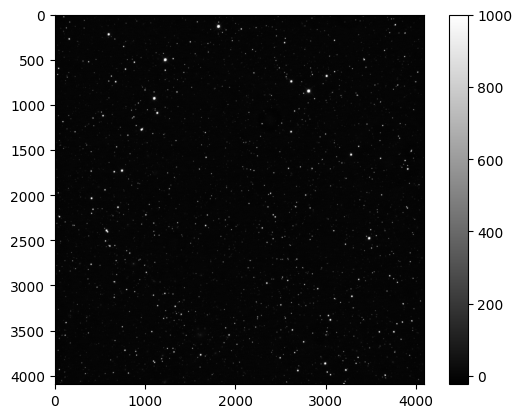

In [7]:
plt.imshow(combined, cmap ='gray', vmin = -23, vmax = 1000)
plt.colorbar()

In [260]:
fits.writeto('combined_image.fits', combined, header=wcs. to_header(), overwrite=True)

In [8]:
background = bg.Background2D(combined, box_size= 65, filter_size = 5, bkg_estimator=MedianBackground())
mean = background.background_median
rms = background.background_rms_median

threshold = background.background + rms * 2

kernel = make_2dgaussian_kernel(3, 3)
convolved_data = convolve(combined, kernel)

segment_map = detect_sources(convolved_data * u.adu, threshold * u.adu, npixels=5)

segm_deblend = deblend_sources(convolved_data, segment_map,
                               npixels=25, nlevels=32, contrast=0.001,
                               progress_bar=True)

In [9]:
rms_array = background.background_rms
error = calc_total_error(np. array(combined), np.asarray(rms_array), 2.2)

source_catalog = SourceCatalog(data = np.asarray(combined), segment_img= segm_deblend, convolved_data = np.array(convolved_data), error = np.asarray(error), wcs= wcs)

image_table = source_catalog.to_table()

In [12]:
galaxy_coords = SkyCoord(ra=galaxy_table['RA'], dec=galaxy_table['Dec'], unit=(u.hourangle, u.deg))

source_coords = image_table['sky_centroid']

idx, separation_2d, _ = galaxy_coords.match_to_catalog_sky(source_coords)

max_separation = 3 * u.arcsec
is_match = separation_2d < max_separation
num_matches = np.sum(is_match)
print(f"{num_matches} matches within a {max_separation} radius")

semimajor_by_galaxy = image_table['semimajor_sigma'][idx].value
psf_sigma = 1.5
is_extended = semimajor_by_galaxy > psf_sigma
final_mask = is_match & is_extended
print(f"{np. sum(final_mask)} extended sources (likely galaxies)")

matched_galaxies = galaxy_table[final_mask]
matched_sources = image_table[idx[final_mask]]
matched_galaxies['separation_arcsec'] = separation_2d[final_mask].to(u.arcsec)

final_table = hstack([matched_galaxies, matched_sources], join_type='exact', table_names=['simbad', 'image'])


useful_cols = ['identifier', 'typ', 'separation_arcsec', 'kron_flux', 'segment_flux', 'RA', 'Dec']
final_cols = [c for c in useful_cols if c in final_table.colnames]
final_table[final_cols].pprint_all()

72 matches within a 3.0 arcsec radius
72 extended sources (likely galaxies)
       identifier       typ  separation_arcsec      kron_flux         segment_flux             RA                 Dec        
                                   arcsec                                                                                    
----------------------- --- ------------------- ------------------ ------------------ ------------------- -------------------
2MASX J19192555+4405063 GiC  1.4230415658955264 27918.166575446012  19456.35223042965 19 19 25.5938951712 +44 05 06.239269140
2MASX J19192570+4342463 GiC 0.48939867603200055 11047.291503367158  8319.631398200989        19 19 25.708        +43 42 46.34
2MASX J19194300+4405083 GiC  1.4734344796731125  11308.35832692554  7899.303565979004 19 19 43.0141404888 +44 05 07.962425592
2MASX J19194633+4400593 GiC  1.5493384014608882  25201.75650515284 10549.403090953827 19 19 46.3432786848 +44 00 59.159961396
2MASX J19195319+4341555 GiC  1.63425604132

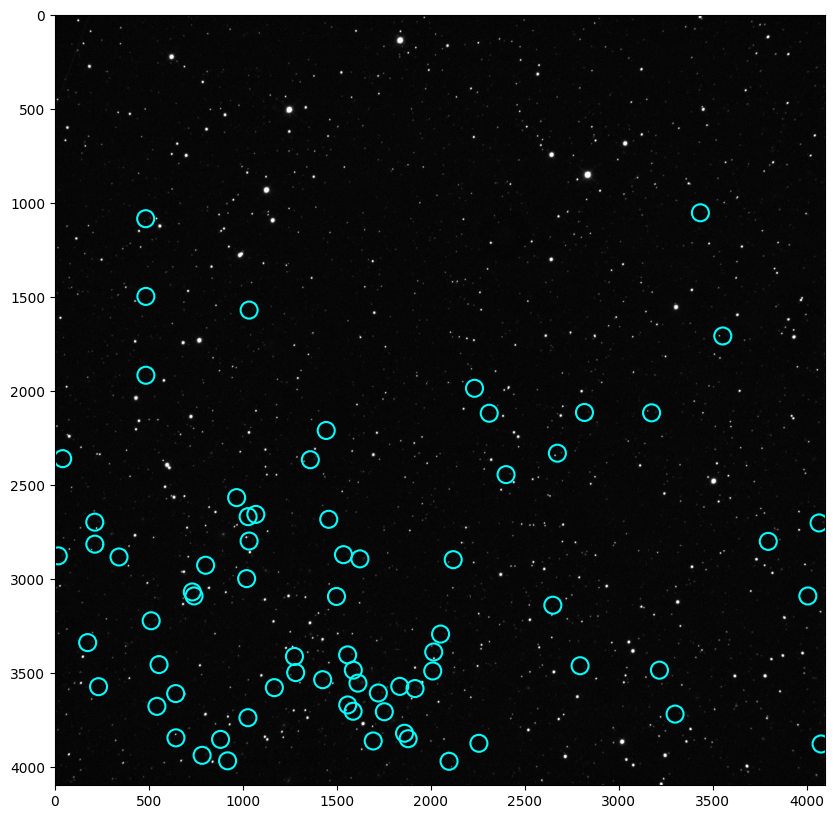

In [13]:
matched_coords = SkyCoord(ra=final_table['RA'],
                          dec=final_table['Dec'],
                          unit=(u.hourangle, u.deg))

ra = matched_coords.ra.deg
dec = matched_coords.dec.deg

pixel_coords = wcs.world_to_pixel_values(ra,dec)
pixel_x = pixel_coords[0]
pixel_y = pixel_coords[1]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(subtracted_background.data, cmap='gray', vmin = -23, vmax = 1000)
ax.scatter(pixel_x, pixel_y, marker='o', s=150, facecolors='none', edgecolors='cyan', lw=1.5, label='Matched SIMBAD Galaxies')
plt.show()

In [14]:
identifiers = final_table['identifier']
custom_simbad = Simbad()
custom_simbad.add_votable_fields('main_id')
custom_simbad. add_votable_fields('velocity')
redshift_results = custom_simbad.query_objects(identifiers)

final_table['redshift'] = redshift_results['rvz_redshift']
final_table['radial_velocity'] = redshift_results['rvz_radvel']

final_table['identifier', 'redshift', 'radial_velocity', 'kron_flux']. pprint_all()

       identifier       redshift  radial_velocity       kron_flux     
                                       km / s                         
----------------------- -------- ------------------ ------------------
2MASX J19192555+4405063 0.051772 15119.593567830923 27918.166575446012
2MASX J19192570+4342463 0.058697 17081.313732268663 11047.291503367158
2MASX J19194300+4405083   0.0625 18152.570851376146  11308.35832692554
2MASX J19194633+4400593 0.051876 15149.160260435398  25201.75650515284
2MASX J19195319+4341555 0.046262 13548.522656812735    9745.1457472755
2MASX J19200066+4405095 0.058634 17063.531274748108 22566.013531014974
2MASX J19200432+4351576 0.040201 11809.894291803712  5421.123572901164
2MASX J19200996+4351216 0.054391  15863.18268356255 11360.019573043937
2MASX J19200996+4347316 0.057416 16719.505378819755 17789.503428368647
2MASX J19201015+4344496 0.052893  15438.11878770817  18583.46638002213
2MASX J19201346+4357556 0.052743 15395.518882238011 11940.908071589596
    NV

In [15]:
corr_table = Table.read('data/V2/corr_1.fits')
print(corr_table[0])

# Reference magnitude (V-band from Tycho)
ref_mag = corr_table['MAG']

# Flux from your image
flux = corr_table['FLUX']

# Remove any bad values
good = (flux > 0) & (ref_mag > 0) & (ref_mag < 20)
ref_mag = ref_mag[good]
flux = flux[good]

# Instrumental magnitude
mag_inst = -2.5 * np.log10(flux)

# Zeropoint for each star
zp_each = ref_mag - mag_inst

# Robust zeropoint (median)
zeropoint = float(np.median(zp_each))
zp_std = float(np. std(zp_each))

print(f"Zeropoint: {zeropoint} ± {zp_std}")
#print(f"Number of stars used: {len(zp_each)}")
#print(f"ZP range: {float(np.min(zp_each)):.3f} to {float(np. max(zp_each)):.3f}")

    field_x           field_y           field_ra         field_dec          index_x           index_y           index_ra         index_dec     index_id field_id    match_weight      MAG          ra_ref           dec_ref        mag    ref_cat        ref_id          pmra      pmdec     parallax   ra_ivar       dec_ivar   pmra_ivar pmdec_ivar parallax_ivar phot_bp_mean_mag phot_rp_mean_mag    FLUX   BACKGROUND
     pixels            pixels           degrees           degrees            pixels            pixels           degrees           degrees        none     none          none                                                                                                                                                                                                                                              
---------------- ----------------- ----------------- ----------------- ----------------- ----------------- ----------------- ----------------- -------- -------- -----------------

In [16]:
zeropoint = 22.24

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
flux = final_table['kron_flux'].value

redshift = np.array(final_table['redshift']).astype(float)

app_mag = -2.5 * np.log10(flux) + zeropoint

dist_lum = cosmo.luminosity_distance(redshift).to(u.pc).value
dist_mod = 5 * np.log10(dist_lum / 10)
abs_mag = app_mag - dist_mod

final_table['app_mag_R'] = app_mag
final_table['abs_mag_R'] = abs_mag

final_table['identifier', 'redshift', 'app_mag_R', 'abs_mag_R'].pprint_all()

       identifier       redshift     app_mag_R           abs_mag_R     
----------------------- -------- ------------------ -------------------
2MASX J19192555+4405063 0.051772 10.725282764577019  -26.08770037225998
2MASX J19192570+4342463 0.058697 11.731860465428339 -25.364477373706023
2MASX J19194300+4405083   0.0625 11.706501096286482 -25.532015323744695
2MASX J19194633+4400593 0.051876 10.836422972062948 -25.981080098934115
2MASX J19195319+4341555 0.046262 11.868029153099053  -24.69197075591849
2MASX J19200066+4405095 0.058634 10.956362889456424  -26.13754572423378
2MASX J19200432+4351576 0.040201 12.504776732482235 -23.740711894994625
2MASX J19200996+4351216 0.054391 11.701552300863192 -25.222669535310352
2MASX J19200996+4347316 0.057416  11.21459043632887  -25.83185209619232
2MASX J19201015+4344496 0.052893 11.167183184238219 -25.694063702912352
2MASX J19201346+4357556 0.052743 11.647406612772741  -25.20743975456226
    NVSS J192017+434851 0.064635  10.68069407589402 -26.63403568

In [20]:
mag_absolute = final_table['abs_mag_R']

M_sun_R = 4.42
M_L_ratio = 3

L_solar = 10**((M_sun_R - mag_absolute) / 2.5)
M_luminous = M_L_ratio * L_solar

final_table['L_solar'] = L_solar
final_table['M_luminous'] = M_luminous

final_table['identifier', 'redshift', 'abs_mag_R', 'L_solar', 'M_luminous'].pprint()

       identifier       redshift ...      L_solar           M_luminous    
----------------------- -------- ... ------------------ ------------------
2MASX J19192555+4405063 0.051772 ... 1596173693387.5571  4788521080162.672
2MASX J19192570+4342463 0.058697 ...  819956757719.3285 2459870273157.9854
2MASX J19194300+4405083   0.0625 ...   956766872034.407 2870300616103.2207
2MASX J19194633+4400593 0.051876 ... 1446878421094.3271 4340635263282.9814
2MASX J19195319+4341555 0.046262 ...  441355255490.2521 1324065766470.7563
2MASX J19200066+4405095 0.058634 ... 1671160991393.5984  5013482974180.795
2MASX J19200432+4351576 0.040201 ... 183774291879.41132  551322875638.2339
2MASX J19200996+4351216 0.054391 ...  719561327143.9048 2158683981431.7144
2MASX J19200996+4347316 0.057416 ... 1261074774409.7305 3783224323229.1914
2MASX J19201015+4344496 0.052893 ... 1110773425916.9792 3332320277750.9375
                    ...      ... ...                ...                ...
2MASX J19212126+4354524 0

In [23]:
total = sum(final_table['M_luminous'])
#ICM 15% of gravitating mass Diffuse radio emission from the intracluster medium L. Feretti a,* , C. Burigana b , T.A. Enßlin c


In [24]:
full_mass = 1.537017e16
plasma_mass = full_mass*0.15
DARKMATTER = full_mass - plasma_mass - total
print(f"FOUND IT {DARKMATTER}, thats {DARKMATTER/full_mass}")

FOUND IT 1.281342899881186e+16, thats 0.8336556458914807
